# 🎦**AlloCiné Data Analysis**📊

We had web scraped the [movies](https://github.com/Bastien-LDC/Allocine-Recommender-System/blob/master/Webscraping/Webscraping_Movies_From_AlloCine.ipynb), [series](https://github.com/Bastien-LDC/Allocine-Recommender-System/blob/master/Webscraping/Webscraping_Series_From_AlloCine.ipynb), and [ratings](https://github.com/Bastien-LDC/Allocine-Recommender-System/blob/master/Webscraping/Webscraping_Ratings_From_AlloCine.ipynb) data from the [AlloCiné](https://www.allocine.fr/) website.

**Data description :**

Features|Movies|Series|Ratings
-------|---------|---------|---
`id`|X|X|-
`title`|X|X|-
`status`|-|X|-
`release_date`|X|X|-
`duration`|X|X|-
`nb_seasons`|-|X|-
`nb_episodes`|-|X|-
`genres`|X|X|-
`directors`|X|X|-
`actors`|X|X|-
`nationality`|X|X|-
`press_rating`|X|X|X
`nb_press_rating`|X|X|-
`spect_rating`|X|X|X
`nb_spect_rating`|X|X|-
`summary`|X|X|-
`poster_link`|X|X|-
`user_id`|-|-|X
`(user/press)_name`|-|-|X
`(movie/series)_id`|-|-|X
`date`|-|-|X


If you are interested in, the data is available on one csv (brut and clean version) [allocine_dataset.zip](http://olivier-maillot.fr/wp-content/uploads/2017/08/allocine_dataset.zip) or in multiple csv files (clean version only) [allocine_rel-dataset.zip](http://olivier-maillot.fr/wp-content/uploads/2017/08/allocine_rel-dataset.zip).

---
# **Import libs**

In [399]:
# import libraries
import pandas as pd
import numpy as np
import random as rd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import os
from warnings import filterwarnings
import missingno as msno

# We ignore reindexing warnings
filterwarnings("ignore",message="Boolean Series key will be reindexed")
%matplotlib inline

# **Data cleaning**

## Saving files

In [400]:
# Save all the dataframes from data in a csv file
def save_data(df: pd.DataFrame, path:str, name: str):
    # We create the folder if not exists
    os.makedirs(os.path.dirname(path), exist_ok=True)
    df.to_csv(f"{path}{name}.csv", index=False)
    print(f"File successfully saved in {path}{name}.csv")

## Load the csv files

In [401]:
def load_csv():
    '''
    Load the csv file and return a dataframe
    '''
    root_path = f"../Saved Data/"
    movies = pd.read_csv(f"{root_path}allocine_movies.csv")
    series = pd.read_csv(f"{root_path}allocine_series.csv")
    press_movies = pd.read_csv(f"{root_path}press_ratings_movies.csv")
    press_series = pd.read_csv(f"{root_path}press_ratings_series.csv")
    user_movies = pd.read_csv(f"{root_path}user_ratings_movies.csv")
    user_series = pd.read_csv(f"{root_path}user_ratings_series.csv")
    return {"movies":movies, "series":series, "press_movies":press_movies, "press_series":press_series, "user_movies":user_movies, "user_series":user_series}
data = load_csv()
movies, series, press_movies, press_series, user_movies, user_series = data["movies"], data["series"], data["press_movies"], data["press_series"], data["user_movies"], data["user_series"]

## Rename and store columns names

In [402]:
# Rename (nb_)spec_rating to (nb_)user_rating
movies.rename(columns={'spect_rating':'user_rating', 'nb_spect_rating':'nb_user_rating'}, inplace=True)
series.rename(columns={'spect_rating':'user_rating', 'nb_spect_rating':'nb_user_rating'}, inplace=True)

In [403]:
# Store columns names
movies_cols = movies.columns
series_cols = series.columns
press_movies_cols = press_movies.columns
press_series_cols = press_series.columns
user_movies_cols = user_movies.columns
user_series_cols = user_series.columns

## Drop duplicates and NaN rating values

In [404]:
m_duplicates = movies.duplicated(subset=["id"]).sum()
s_duplicates = series.duplicated(subset=["id"]).sum()
pm_duplicates = press_movies.duplicated().sum()
ps_duplicates = press_series.duplicated().sum()
um_duplicates = user_movies.duplicated().sum()
us_duplicates = user_series.duplicated().sum()
print(f"Nb of movie duplicates: {m_duplicates}")
print(f"Nb of series duplicates: {s_duplicates}")
print(f"Nb of press movie duplicates: {pm_duplicates}")
print(f"Nb of press series duplicates: {ps_duplicates}")
print(f"Nb of user movie duplicates: {um_duplicates}")
print(f"Nb of user series duplicates: {us_duplicates}")
series.drop_duplicates(subset=["id"], inplace=True, ignore_index=True)
movies.drop_duplicates(subset=["id"], inplace=True, ignore_index=True)
press_movies.drop_duplicates(inplace=True, ignore_index=True)
press_series.drop_duplicates(inplace=True, ignore_index=True)
user_movies.drop_duplicates(inplace=True, ignore_index=True)
user_series.drop_duplicates(inplace=True, ignore_index=True)
print("--> All duplicates removed")

Nb of movie duplicates: 119
Nb of series duplicates: 125
Nb of press movie duplicates: 649
Nb of press series duplicates: 158
Nb of user movie duplicates: 2463
Nb of user series duplicates: 2184
--> All duplicates removed


In [405]:
# Drop series and movies with no press AND no user ratings
m_na_ratings = movies[movies["press_rating"].isna()][movies["user_rating"].isna()].shape[0]
s_na_ratings = series[series["press_rating"].isna()][series["user_rating"].isna()].shape[0]
movies.dropna(subset=["nb_press_rating","nb_user_rating","press_rating","user_rating"], inplace=True, how="all")
series.dropna(subset=["nb_press_rating","nb_user_rating","press_rating","user_rating"], inplace=True, how="all")
print(f"Number of movies with no ratings: {m_na_ratings}")
print(f"Number of series with no ratings: {s_na_ratings}")
print("--> All movies and series with no ratings removed")

Number of movies with no ratings: 9
Number of series with no ratings: 1117
--> All movies and series with no ratings removed


In [406]:
# Drop series with "Divers" as genre
series.drop(series[series.genres.apply(lambda x: "Divers" in x)].index, inplace=True)
# Drop series with "Datedesortieinconnue" as release_date
series.drop(series[series.release_date == "Datedesortieinconnue"].index, inplace=True)

## Convert the strings to arrays

In [407]:
def convert_to_array(df: pd.DataFrame):
    '''
    Convert the strings to arrays
    '''
    df["genres"] = df["genres"].apply(lambda x: x.split(", ") if type(x) not in [float,list] else x)
    df["directors"] = df["directors"].apply(lambda x: x.split(", ") if type(x) not in [float,list] else x)
    df["actors"] = df["actors"].apply(lambda x: x.split(", ") if type(x) not in [float,list] else x)
    df["nationality"] = df["nationality"].apply(lambda x: x.split(", ") if type(x) not in [float,list] else x)

In [408]:
convert_to_array(movies)
convert_to_array(series)
# Convert nb_spec_rating and nb_press_rating to int
#movies[["nb_press_rating","nb_user_rating"]] = movies[["nb_press_rating","nb_user_rating"]].astype(int)
#series[["nb_press_rating","nb_user_rating"]] = series[["nb_press_rating","nb_user_rating"]].astype(int)

## Create new tables

### *GENRE*

#### *Create `genres` dataframes*

In [409]:
def create_genre_df(df_key: str):
    # Get dataframe from key
    df = data.get(df_key)
    genre_df = None
    if df is not None:  
        df = df.copy()      
        # Remove all rows with no genres
        df.dropna(subset=["genres"], inplace=True)
        # Get all unique genres from df
        genres_list = [genre.lstrip() for genres in df["genres"] for genre in genres]
        genres_list = sorted(list(set(genres_list))) 
        # Create dataframe with the number of movies per genre from genres_list
        genre_df = pd.DataFrame({"genres": genres_list, f"nb_{df_key}": [df[df["genres"].apply(lambda x: genre in x).values].shape[0] for genre in genres_list]})

        # Add the average duration per genre
        genre_df["avg_duration"] = [int(df[df["genres"].apply(lambda x: genre in x).values]["duration"].mean()) for genre in genres_list]

        # Add the median duration per genre
        genre_df["median_duration"] = [int(df[df["genres"].apply(lambda x: genre in x).values]["duration"].median()) for genre in genres_list]

        # Add the nb_press_rating and nb_user_rating to the genre_df
        genre_df["nb_press_rating"] = [int(df[df["genres"].apply(lambda x: genre in x).values]["nb_press_rating"].sum()) for genre in genres_list]
        genre_df["nb_user_rating"] = [int(df[df["genres"].apply(lambda x: genre in x).values]["nb_user_rating"].sum()) for genre in genres_list]

        # Add the total_rating to the genre_df (press_rating + user_rating)
        genre_df["total_rating"] = genre_df["nb_press_rating"] + genre_df["nb_user_rating"]

        # Add the press_rating_percentage and user_rating_percentage to the genre_df 
        genre_df["press_rating_percentage"] = round(genre_df["nb_press_rating"] / genre_df["nb_press_rating"].values.sum() * 100, 3)
        genre_df["user_rating_percentage"] = round(genre_df["nb_user_rating"] / genre_df["nb_user_rating"].values.sum() * 100, 3)

        # Add the movies/series_percentage to the genre_df
        genre_df[f"{df_key}_percentage"] = round(genre_df[f"nb_{df_key}"]/df.shape[0] * 100, 3)
        return genre_df.sort_values(by = "genres", ascending = True)

In [410]:
m_genres_df = create_genre_df("movies")
s_genres_df = create_genre_df("series")

In [411]:
print(m_genres_df.genres.values)
print(s_genres_df.genres.values)

['Action' 'Animation' 'Arts Martiaux' 'Aventure' 'Biopic' 'Bollywood'
 'Comédie' 'Comédie dramatique' 'Comédie musicale' 'Divers' 'Drame'
 'Epouvante-horreur' 'Erotique' 'Espionnage' 'Expérimental' 'Famille'
 'Fantastique' 'Guerre' 'Historique' 'Judiciaire' 'Musical' 'Policier'
 'Péplum' 'Romance' 'Science fiction' 'Sport event' 'Thriller' 'Western']
['Action' 'Animation' 'Arts Martiaux' 'Aventure' 'Biopic' 'Classique'
 'Comédie' 'Comédie dramatique' 'Comédie musicale' 'Dessin animé'
 'Documentaire' 'Drama' 'Drame' 'Epouvante-horreur' 'Erotique'
 'Espionnage' 'Famille' 'Fantastique' 'Guerre' 'Historique' 'Judiciaire'
 'Mobisode' 'Musical' 'Médical' 'Policier' 'Péplum' 'Romance'
 'Science fiction' 'Show' 'Soap' 'Sport event' 'Thriller' 'Websérie'
 'Western']


#### *Save all `genres` dataframes*

In [412]:
path = "../Cleaned Data/"
save_data(m_genres_df, path, "m_genres")
save_data(s_genres_df, path, "s_genres")

File successfully saved in ../Cleaned Data/m_genres.csv
File successfully saved in ../Cleaned Data/s_genres.csv


### *NATIONALITY*

#### *Create `nationality` dataframes*

In [413]:
def create_nationality_df(df_key: str):
    # Get dataframe from key
    df = data.get(df_key)
    nation_df = None
    if df is not None:        
        df = df.copy()
        # Remove all rows with no nationality
        df.dropna(subset=["nationality"], inplace=True)
        # Get all unique nationality from df
        nationality = [nat.lstrip() for nationality in df["nationality"] for nat in nationality]
        nationality = sorted(list(set(nationality))) 
        # Create dataframe with the number of movies per nationality from nationality list
        nation_df = pd.DataFrame({"nationality": nationality, f"nb_{df_key}": [df[df["nationality"].apply(lambda x: nation in x).values].shape[0] for nation in nationality]})

        # Add the nb_press_rating and nb_user_rating to the nation_df
        nation_df["nb_press_rating"] = [int(df[df["nationality"].apply(lambda x: nation in x).values]["nb_press_rating"].sum()) for nation in nationality]
        nation_df["nb_user_rating"] = [int(df[df["nationality"].apply(lambda x: nation in x).values]["nb_user_rating"].sum()) for nation in nationality]

        # Add the total_rating to the nation_df (press_rating + user_rating)
        nation_df["total_rating"] = nation_df["nb_press_rating"] + nation_df["nb_user_rating"]

        # Add the press_rating_percentage and user_rating_percentage to the nation_df 
        nation_df["press_rating_percentage"] = round(nation_df["nb_press_rating"] / nation_df["nb_press_rating"].values.sum() * 100, 4)
        nation_df["user_rating_percentage"] = round(nation_df["nb_user_rating"] / nation_df["nb_user_rating"].values.sum() * 100, 4)

        # Add the movies/series_percentage to the nation_df
        nation_df[f"{df_key}_percentage"] = round(nation_df[f"nb_{df_key}"]/df.shape[0] * 100, 4)
        return nation_df.sort_values(by = "nationality", ascending = True)

In [414]:
m_nationality_df = create_nationality_df("movies")
s_nationality_df = create_nationality_df("series")

#### *Save all `nationality` dataframes*

In [415]:
path = "../Cleaned Data/"
save_data(m_nationality_df, path, "m_nationality")
save_data(s_nationality_df, path, "s_nationality")

File successfully saved in ../Cleaned Data/m_nationality.csv
File successfully saved in ../Cleaned Data/s_nationality.csv


## Check data coherence

In [416]:
def display_stats(df: pd.DataFrame):
    '''
    Display the statistics of a dataframe
    '''
    # Graph of number of missing values by column
    #msno.heatmap(df, cmap="RdYlBu", sort="ascending")
    msno.matrix(df, figsize=(12,8), color=(round(rd.random(),2),round(rd.random(),2),round(rd.random(),2)), sort="descending")
    missing_values = df.isnull().sum()
    if missing_values.sum() > 0:      
        missing_values = missing_values / df.shape[0] * 100
        missing_values = missing_values[missing_values > 0]
        missing_values.sort_values(inplace=True)
        plt.figure(figsize=(12, 5))
        plt.title(f"Percentage of missing values in each column")
        sns.barplot(x=missing_values.index, y=missing_values)
        plt.show()
    else:
        print("No missing values in the dataframe")
    df.info()
    return df.describe()

### Impute missing duration

In [417]:
def impute_missing_duration(df_key: str):
    '''
    From the m/s_genres_df DataFrames, we order the genres by the number of movies/series with that genre.
    We then compute the median duration of the movies/series with that genre.
    Finally, we impute the missing duration of the movies/series with the median duration of the movies/series with the most popular genre among their genres.
    '''
    # Get dataframe from key
    df = data.get(df_key)
    genres_df = m_genres_df if df_key == "movies" else s_genres_df if df_key == "series" else None
    if df is not None:
        df = df.copy()
        # Get the movies/serie with missing duration
        df_na_duration = df[df["duration"].isna()]
        for index, row in df_na_duration.iterrows():
            # Get the genres of each movies/series from the m/s_genres_df DataFrame
            na_duration_genres = genres_df.loc[genres_df.genres.isin(row["genres"])]
            # Get the genre with the most movies/series from the na_duration_genres DataFrame
            most_pop_genre = na_duration_genres.sort_values(by = f"nb_{df_key}", ascending = False).iloc[0]["genres"]
            # Retrieve the median duration of the movies/series with the most popular genre
            median_duration = int(genres_df[genres_df.genres == most_pop_genre].median_duration)
            # Impute the missing duration of the movies/series with the median duration of the most popular genre
            df.loc[index, "duration"] = median_duration
    return df

### Series

In [418]:
# Replace the release_date string by the release year as a date 
# Get all the 4-digits numbers from a string and keep only the first one, which is the release year. 
series["release_date"] = series["release_date"].apply(lambda x: int(re.findall(r"\d{4}", x)[0]))

#### Stats

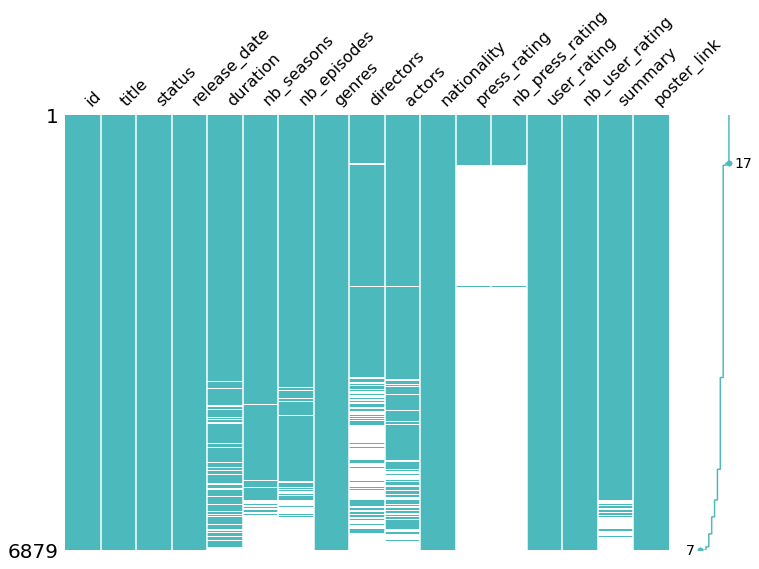

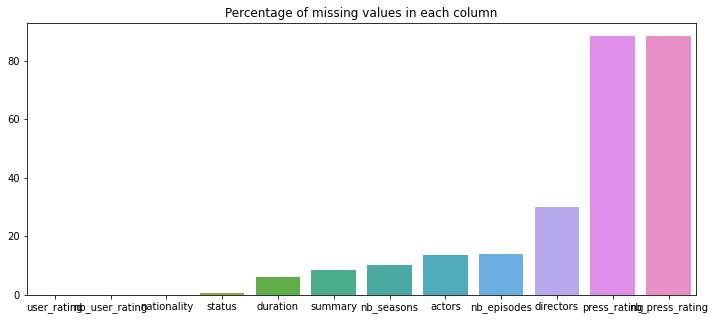

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6879 entries, 0 to 8000
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               6879 non-null   int64  
 1   title            6879 non-null   object 
 2   status           6843 non-null   object 
 3   release_date     6879 non-null   int64  
 4   duration         6465 non-null   float64
 5   nb_seasons       6167 non-null   float64
 6   nb_episodes      5925 non-null   float64
 7   genres           6879 non-null   object 
 8   directors        4816 non-null   object 
 9   actors           5947 non-null   object 
 10  nationality      6871 non-null   object 
 11  press_rating     792 non-null    float64
 12  nb_press_rating  792 non-null    float64
 13  user_rating      6878 non-null   float64
 14  nb_user_rating   6878 non-null   float64
 15  summary          6302 non-null   object 
 16  poster_link      6879 non-null   object 
dtypes: float64(7),

,id,release_date,duration,nb_seasons,nb_episodes,press_rating,nb_press_rating,user_rating,nb_user_rating
count,6879.000000,6879.000000,6465.000000,6167.000000,5925.000000,792.000000,792.000000,6878.000000,6878.000000
mean,15050.246257,2009.102777,40.764424,2.477055,43.618565,3.245202,8.095960,3.269352,964.035766
std,9661.992519,13.241765,20.613930,3.240308,249.846859,0.611625,3.528591,0.516526,5727.422398
min,1.000000,1929.000000,1.000000,1.000000,1.000000,1.300000,1.000000,0.800000,1.000000
25%,5547.500000,2004.000000,25.000000,1.000000,8.000000,2.800000,6.000000,3.000000,7.000000
50%,17155.000000,2013.000000,42.000000,1.000000,16.000000,3.300000,8.000000,3.200000,36.000000
75%,23988.500000,2019.000000,52.000000,3.000000,39.000000,3.700000,10.000000,3.600000,189.000000
max,31747.000000,2022.000000,240.000000,59.000000,13484.000000,5.000000,30.000000,4.700000,206012.000000


In [419]:
s_stats = display_stats(series)
s_stats

In [430]:
# Find the series where nb_seasons is greater or equal to nb_episodes 
series[series.nb_seasons > series.nb_episodes]

,id,title,status,release_date,duration,nb_seasons,nb_episodes,genres,directors,actors,nationality,press_rating,nb_press_rating,user_rating,nb_user_rating,summary,poster_link
436,19874,La Petite Histoire de France,En cours,2015,3.0,4.0,1.0,"[Comédie, Historique]","[Jamel Debbouze, Laurent Tiphaine, Frank Cimière]","[Maxime Gasteuil, David Salles, Karina Marimon]",[France],NaN,NaN,2.9,528.0,"Tout le monde connaît Jeanne d'Arc, Louis XIV ...",https://fr.web.img4.acsta.net/c_310_420/pictur...
1614,12101,Parents mode d'emploi (2013),Terminée,2013,3.0,7.0,5.0,[Comédie],"[Blanche Gardin, Béatrice Fournera, Eve-Sophie...","[Alix Poisson, Arnaud Ducret, Orféo Campanella]",[France],NaN,NaN,2.8,229.0,"Isa et Gaby, un couple de quadragénaires, pare...",https://fr.web.img4.acsta.net/c_310_420/pictur...
1627,9588,Soda,Terminée,2011,3.0,4.0,2.0,[Comédie],"[Frank Bellocq, David Soussan, Kev Adams]","[Kev Adams, William Lebghil, Guy Lecluyse]",[France],NaN,NaN,2.5,3829.0,Fils aîné d’une famille de classe moyenne et m...,https://fr.web.img6.acsta.net/c_310_420/medias...
2090,16855,Pep's,Terminée,2013,5.0,3.0,1.0,[Comédie],"[Céline Guyot, Martin Guyot]","[Charlotte des Georges, Jean-Michel Lahmi, Yan...",[France],NaN,NaN,2.4,211.0,"Que l'on y travaille comme professeur, que l'o...",https://fr.web.img6.acsta.net/c_310_420/pictur...
2217,7237,Fate/Stay Night,Terminée,2014,25.0,2.0,1.0,[Animation],"[Akira Hiyama, Kazuharu Sato]",NaN,[Japon],NaN,NaN,3.8,65.0,"Emiya Shirô, fils adoptif d’un mage défunt, se...",https://fr.web.img4.acsta.net/c_310_420/medias...
2943,296,Kung Fu,Terminée,1972,42.0,3.0,1.0,"[Drame, Action]",[Ed Spielman],"[David Carradine, Keith Carradine, John Blyth ...",[U.S.A.],NaN,NaN,2.5,1374.0,"A la recherche de son frère, Kwai Chang Caine ...",https://fr.web.img6.acsta.net/c_310_420/medias...
3973,19724,T.,Terminée,2015,52.0,3.0,1.0,"[Drame, Thriller]",NaN,"[Koen De Bouw, Ella Leyers, Herwig Ilegems]",[Belgique],NaN,NaN,3.0,1.0,"Jasper Teerlinck, alias ""Professeur T."", la qu...",https://fr.web.img6.acsta.net/c_310_420/pictur...
5165,7508,Land Girls,Terminée,2009,45.0,3.0,1.0,[Drame],NaN,NaN,[Grande-Bretagne],NaN,NaN,3.2,22.0,"Suivez le quotidien, les amours et les hauts e...",https://fr.web.img6.acsta.net/c_310_420/common...
6175,4784,Tokyo Demon Campus,En cours,2007,25.0,2.0,1.0,"[Action, Animation]",[Toshizo Nemoto],NaN,[Japon],NaN,NaN,3.0,10.0,Tokyo est depuis peu la proie de crimes d'un n...,https://fr.web.img2.acsta.net/c_310_420/medias...
7650,11528,Chambres en ville,Terminée,1989,52.0,7.0,1.0,"[Drame, Soap]",[Sylvie Payette],"[Louise Deschâtelets, Gregory Charles, Valérie...",[Canada],NaN,NaN,3.1,3.0,Louise Leblanc est propriétaire d'une résidenc...,https://fr.web.img5.acsta.net/c_310_420/medias...


#### Impute missing duration

In [421]:
series = impute_missing_duration("series")

### Movies

In [422]:
def get_release_season(date: str):
    '''
    Get the release season
    '''
    spring = "03-21"
    summer = "06-21"
    fall = "09-21"
    winter = "12-21"
    my = re.sub(r"\d{4}-", "", date)
    if my < spring or my >= winter:
        return "Winter"
    elif my < summer and my >= spring:
        return "Spring"
    elif my < fall and my >= summer:
        return "Summer"
    elif my < winter and my >= fall:
        return "Fall"

In [423]:
# Keep only the year and the month of the release date
# movies["release_date"] = movies["release_date"].apply(lambda x: x.split("-")[0]+"-"+x.split("-")[1])

# Get the release season
movies["release_date"] = movies["release_date"].apply(lambda x: get_release_season(x) + " " + x.split("-")[0])


In [424]:
#print(sorted(set(movies.release_date.values),reverse=False))

In [425]:
movies = impute_missing_duration("movies")

In [426]:
m_genres_df.sort_values(by = "nb_movies", ascending = False).head(10)

,genres,nb_movies,avg_duration,median_duration,nb_press_rating,nb_user_rating,total_rating,press_rating_percentage,user_rating_percentage,movies_percentage
10,Drame,3275,113,109,40882,12966409,13007291,23.941,13.823,41.466
6,Comédie,2000,100,99,23074,11823748,11846822,13.512,12.605,25.323
26,Thriller,1667,108,105,16488,8405278,8421766,9.656,8.961,21.107
0,Action,1275,112,110,12795,12131275,12144070,7.493,12.933,16.143
23,Romance,885,110,106,9206,4211642,4220848,5.391,4.490,11.205
3,Aventure,868,111,106,9946,8799177,8809123,5.825,9.380,10.990
21,Policier,686,110,108,6069,4781005,4787074,3.554,5.097,8.686
11,Epouvante-horreur,678,98,96,5246,2392325,2397571,3.072,2.550,8.584
16,Fantastique,654,110,105,7994,7191710,7199704,4.681,7.667,8.281
24,Science fiction,570,110,108,6372,6517170,6523542,3.732,6.948,7.217


In [427]:
movies[movies.id == 291764]

,id,title,release_date,duration,genres,directors,actors,nationality,press_rating,nb_press_rating,user_rating,nb_user_rating,summary,poster_link
1634,291764,Rocky IV: Rocky Vs. Drago,Winter 2022,109.0,"[Drame, Action]","[Jeb Stuart, Sylvester Stallone]","[Sylvester Stallone, Dolph Lundgren, Carl Weat...",[USA],NaN,NaN,4.0,113.0,"La version ""Director's Cut"" par Sylvester Stal...",https://fr.web.img6.acsta.net/c_310_420/pictur...


#### Stats

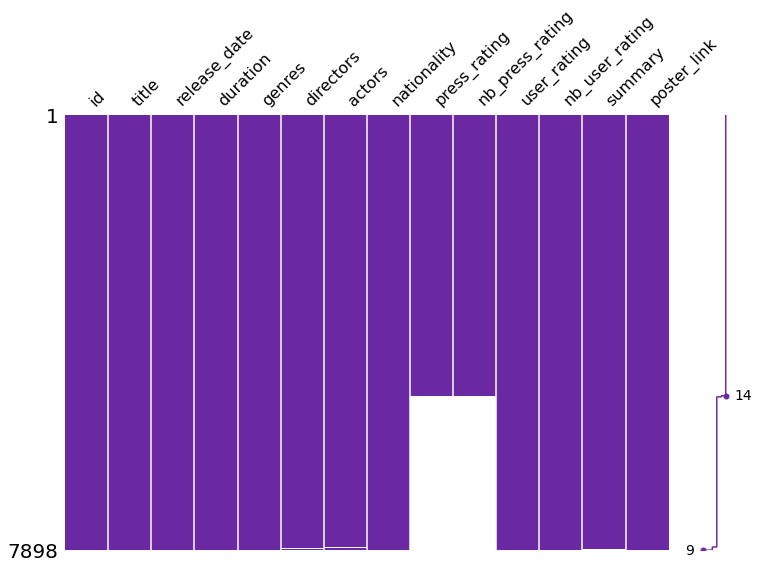

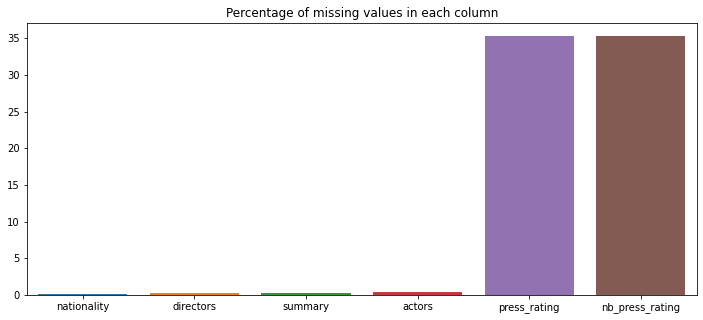

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7898 entries, 0 to 7906
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               7898 non-null   int64  
 1   title            7898 non-null   object 
 2   release_date     7898 non-null   object 
 3   duration         7898 non-null   float64
 4   genres           7898 non-null   object 
 5   directors        7878 non-null   object 
 6   actors           7864 non-null   object 
 7   nationality      7890 non-null   object 
 8   press_rating     5111 non-null   float64
 9   nb_press_rating  5111 non-null   float64
 10  user_rating      7898 non-null   float64
 11  nb_user_rating   7898 non-null   float64
 12  summary          7875 non-null   object 
 13  poster_link      7898 non-null   object 
dtypes: float64(5), int64(1), object(8)
memory usage: 1.2+ MB


,id,duration,press_rating,nb_press_rating,user_rating,nb_user_rating
count,7898.000000,7898.000000,5111.000000,5111.000000,7898.000000,7898.000000
mean,150481.210180,107.923018,3.247388,17.464880,3.140491,5563.583059
std,104553.465455,21.594608,0.738463,8.656134,0.732848,12946.183790
min,1.000000,26.000000,1.000000,1.000000,0.800000,1.000000
25%,37106.250000,95.000000,2.800000,11.000000,2.600000,394.000000
50%,176718.000000,104.000000,3.300000,18.000000,3.200000,1501.500000
75%,250618.750000,118.000000,3.700000,24.000000,3.700000,4724.750000
max,303494.000000,450.000000,5.000000,45.000000,4.600000,218842.000000


In [428]:
m_stats = display_stats(movies)
m_stats

## Save Cleaned datasets

In [429]:
path = "../Cleaned Data/"
for k,v in data.items():
    save_data(v, path, k)

File successfully saved in ../Cleaned Data/movies.csv
File successfully saved in ../Cleaned Data/series.csv
File successfully saved in ../Cleaned Data/press_movies.csv
File successfully saved in ../Cleaned Data/press_series.csv
File successfully saved in ../Cleaned Data/user_movies.csv
File successfully saved in ../Cleaned Data/user_series.csv


# **Section 1. Ratings Distributions**

## Plot the Distribution of Ratings 

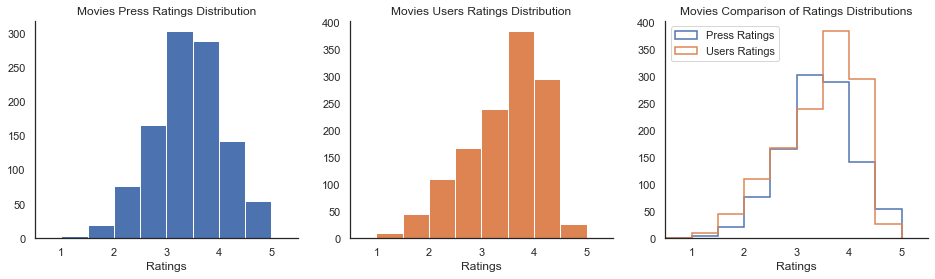

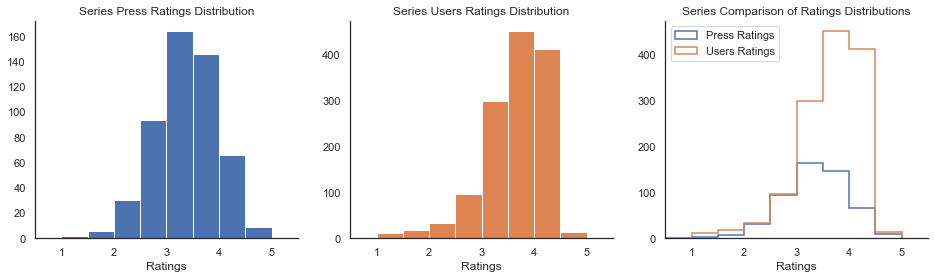

In [224]:
for k,df in list(data.items())[:2]:
    sns.set(style="white", palette="deep")

    fig, axes = plt.subplots(1, 3, figsize = (16,4))
    ax1, ax2, ax3 = fig.axes

    ax1.set_xlim([0.5,5.5])
    ax2.set_xlim([0.5,5.5])
    ax3.set_xlim([0.5,5.5])


    ax1.hist(df["press_rating"], bins = 10, range = (0,5), color='C0') # bin range = 1
    ax1.set_title(f'{k.title()} Press Ratings Distribution')
    ax1.set_xlabel('Ratings')

    ax2.hist(df["user_rating"], bins = 10, range = (0,5), color='C1') # bin range = 1
    ax2.set_title(f'{k.title()} Users Ratings Distribution')
    ax2.set_xlabel('Ratings')

    ax3.hist(df["press_rating"], bins = 10, range = (0,5), histtype = 'step', 
            lw=1.5, label='Press Ratings', color='C0')
    ax3.hist(df["user_rating"], bins = 10, range = (0,5), histtype = 'step', 
            lw=1.5, label='Users Ratings', color='C1')
    ax3.legend(loc = 'upper left')
    ax3.set_title(f'{k.title()} Comparison of Ratings Distributions')
    ax3.set_xlabel('Ratings')

    for ax in fig.axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

In [225]:
# save the fig
#fig.savefig('allocine-0_hist.png', bbox_inches='tight', dpi=200)

## Ratings Correlation

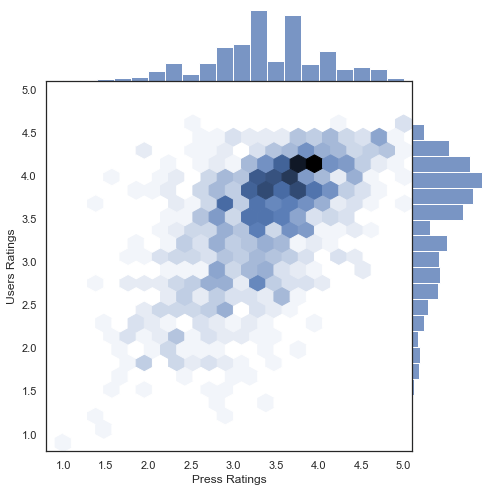

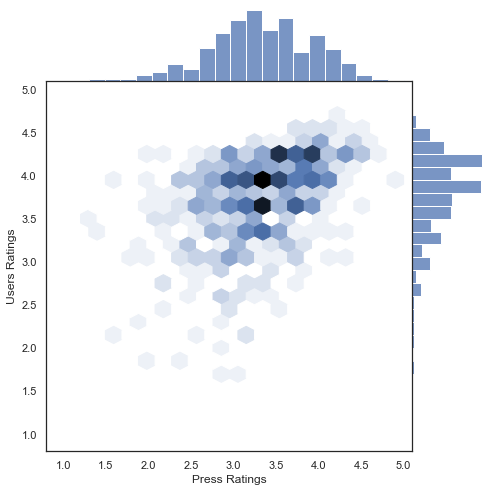

In [226]:
# Correlation between press_rating and user_rating
for k,df in list(data.items())[:2]:
    ax = sns.jointplot(x="press_rating", y="user_rating", 
                    data=df, kind="hex",
                    marginal_kws=dict(bins=20),
                    xlim=(0.8,5.1), ylim=(0.8,5.1),
                    height=7, space=0).set_axis_labels("Press Ratings", "Users Ratings")

In [227]:
# save the fig
#ax.savefig('allocine-1_jointplot.png', bbox_inches='tight', dpi=200)

## Compare to users ratings

five_stars = allocine[allocine["press_rating"] >= 5]
f, ax = plt.subplots(figsize=(15,6))
f.suptitle('Movies with Five Stars From The Press', 
           fontsize=13)
f.subplots_adjust(top=0.85)

sns.countplot(x=five_stars["user_rating"], ax=ax)
ax.set_xlabel("Users Ratings")
ax.set_ylabel("")
sns.despine(top=True, right=True, left=False, bottom=False)

### save the fig
f.savefig('allocine-2_hist5stars.png', bbox_inches='tight', dpi=200)

### # print the first tier and second tier of the Users Ratings
allocine[["user_rating"]].quantile([.33,.66])

p = (len(five_stars[(five_stars["user_rating"] < 2.9)]) / len(five_stars)) * 100
print('{} % of the movies with the highest press ratings received a low users ratings.'.format(round(p, 2)))
p = (len(five_stars[(five_stars["user_rating"] < 3.4) & (five_stars["user_rating"] >= 2.9)]) / len(five_stars)) * 100
print('{} % of the movies with the highest press ratings received a moderate users ratings.'.format(round(p, 2)))
p = (len(five_stars[five_stars["user_rating"] >= 3.4]) / len(five_stars)) * 100
print('{} % of the movies with the highest press ratings received a high users ratings.'.format(round(p, 2)))

# **Section 3. Data Exploration**

## **GENRE**

### *Create `genres` dataframes*

In [254]:
def create_genre_df(df_key: str):
    # Get dataframe from key
    df = data.get(df_key)
    genre_df = None
    if df is not None:  
        df = df.copy()      
        # Remove all rows with no genres
        df.dropna(subset=["genres"], inplace=True)
        # Get all unique genres from df
        genres_list = [genre.lstrip() for genres in df["genres"] for genre in genres]
        genres_list = sorted(list(set(genres_list))) 
        # Create dataframe with the number of movies per genre from genres_list
        genre_df = pd.DataFrame({"genres": genres_list, f"nb_{df_key}": [df[df["genres"].apply(lambda x: genre in x).values].shape[0] for genre in genres_list]})

        # Add the average duration per genre
        genre_df["avg_duration"] = [int(df[df["genres"].apply(lambda x: genre in x).values]["duration"].mean()) for genre in genres_list]

        # Add the median duration per genre
        genre_df["median_duration"] = [int(df[df["genres"].apply(lambda x: genre in x).values]["duration"].median()) for genre in genres_list]

        # Add the nb_press_rating and nb_user_rating to the genre_df
        genre_df["nb_press_rating"] = [int(df[df["genres"].apply(lambda x: genre in x).values]["nb_press_rating"].sum()) for genre in genres_list]
        genre_df["nb_user_rating"] = [int(df[df["genres"].apply(lambda x: genre in x).values]["nb_user_rating"].sum()) for genre in genres_list]

        # Add the total_rating to the genre_df (press_rating + user_rating)
        genre_df["total_rating"] = genre_df["nb_press_rating"] + genre_df["nb_user_rating"]

        # Add the press_rating_percentage and user_rating_percentage to the genre_df 
        genre_df["press_rating_percentage"] = round(genre_df["nb_press_rating"] / genre_df["nb_press_rating"].values.sum() * 100, 3)
        genre_df["user_rating_percentage"] = round(genre_df["nb_user_rating"] / genre_df["nb_user_rating"].values.sum() * 100, 3)

        # Add the movies/series_percentage to the genre_df
        genre_df[f"{df_key}_percentage"] = round(genre_df[f"nb_{df_key}"]/df.shape[0] * 100, 3)
        return genre_df.sort_values(by = "genres", ascending = True)

In [255]:
m_genres_df = create_genre_df("movies")
s_genres_df = create_genre_df("series")

In [232]:
print(m_genres_df.genres.values)
print(s_genres_df.genres.values)

['Action' 'Animation' 'Arts Martiaux' 'Aventure' 'Biopic' 'Comédie'
 'Comédie dramatique' 'Comédie musicale' 'Drame' 'Epouvante-horreur'
 'Erotique' 'Espionnage' 'Famille' 'Fantastique' 'Guerre' 'Historique'
 'Judiciaire' 'Musical' 'Policier' 'Péplum' 'Romance' 'Science fiction'
 'Sport event' 'Thriller' 'Western']
['Action' 'Animation' 'Arts Martiaux' 'Aventure' 'Biopic' 'Comédie'
 'Comédie dramatique' 'Comédie musicale' 'Dessin animé' 'Documentaire'
 'Drame' 'Epouvante-horreur' 'Erotique' 'Espionnage' 'Famille'
 'Fantastique' 'Guerre' 'Historique' 'Judiciaire' 'Musical' 'Médical'
 'Policier' 'Péplum' 'Romance' 'Science fiction' 'Show' 'Soap'
 'Sport event' 'Thriller' 'Websérie' 'Western']


### *Save all `genres` dataframes*

In [25]:
path = "../Cleaned Data/"
save_data(m_genres_df, path, "m_genres")
save_data(s_genres_df, path, "s_genres")

File successfully saved in ../Cleaned Data/m_genres.csv
File successfully saved in ../Cleaned Data/s_genres.csv


## **NATIONALITY**

### *Create `nationality` dataframes*

In [26]:
def create_nationality_df(df_key: str):
    # Get dataframe from key
    df = data.get(df_key)
    nation_df = None
    if df is not None:        
        df = df.copy()
        # Remove all rows with no nationality
        df.dropna(subset=["nationality"], inplace=True)
        # Get all unique nationality from df
        nationality = [nat.lstrip() for nationality in df["nationality"] for nat in nationality]
        nationality = sorted(list(set(nationality))) 
        # Create dataframe with the number of movies per nationality from nationality list
        nation_df = pd.DataFrame({"nationality": nationality, f"nb_{df_key}": [df[df["nationality"].apply(lambda x: nation in x).values].shape[0] for nation in nationality]})

        # Add the nb_press_rating and nb_user_rating to the nation_df
        nation_df["nb_press_rating"] = [int(df[df["nationality"].apply(lambda x: nation in x).values]["nb_press_rating"].sum()) for nation in nationality]
        nation_df["nb_user_rating"] = [int(df[df["nationality"].apply(lambda x: nation in x).values]["nb_user_rating"].sum()) for nation in nationality]

        # Add the total_rating to the nation_df (press_rating + user_rating)
        nation_df["total_rating"] = nation_df["nb_press_rating"] + nation_df["nb_user_rating"]

        # Add the press_rating_percentage and user_rating_percentage to the nation_df 
        nation_df["press_rating_percentage"] = round(nation_df["nb_press_rating"] / nation_df["nb_press_rating"].values.sum() * 100, 4)
        nation_df["user_rating_percentage"] = round(nation_df["nb_user_rating"] / nation_df["nb_user_rating"].values.sum() * 100, 4)

        # Add the movies/series_percentage to the nation_df
        nation_df[f"{df_key}_percentage"] = round(nation_df[f"nb_{df_key}"]/df.shape[0] * 100, 4)
        return nation_df.sort_values(by = "nationality", ascending = True)

In [27]:
m_nationality_df = create_nationality_df("movies")
s_nationality_df = create_nationality_df("series")

### *Save all `nationality` dataframes*

In [31]:
path = "../Cleaned Data/"
save_data(m_nationality_df, path, "m_nationality")
save_data(s_nationality_df, path, "s_nationality")

File successfully saved in ../Cleaned Data/m_nationality.csv
File successfully saved in ../Cleaned Data/s_nationality.csv
